<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/Linear_classifier_on_sensor_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import mne
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import Vectorizer, get_coef

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from mne.decoding import LinearModel

data_path = sample.data_path()
sample_path = data_path / 'MEG' / 'sample'


In [8]:
raw_fname = sample_path / 'sample_audvis_filt-0-40_raw.fif'
event_fname = sample_path / 'sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0.1, 0.4
event_id = dict(aud_l=1, vis_l=3)

raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(.5, 25, fir_design='firwin')
events = mne.read_events(event_fname)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    decim=2, baseline=None, preload=True)
del raw

labels = epochs.events[:, -1]

meg_epochs = epochs.copy().pick_types(meg=True, eeg=False)
meg_data = meg_epochs.get_data().reshape(len(labels), -1)

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 993 samples (6.613 sec)

Not setting metadata
145 matching eve

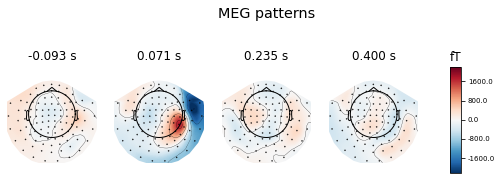

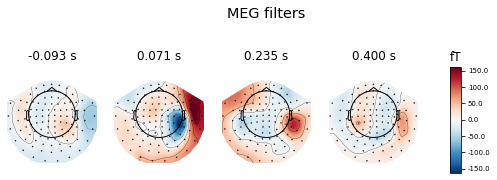

In [9]:
clf = LogisticRegression(solver='liblinear') 
scaler = StandardScaler()

model = LinearModel(clf)

X = scaler.fit_transform(meg_data)
model.fit(X, labels)

for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    coef = scaler.inverse_transform([coef])[0]
    coef = coef.reshape(len(meg_epochs.ch_names), -1)
    evoked = EvokedArray(coef, meg_epochs.info, tmin=epochs.tmin)
    evoked.plot_topomap(title='MEG %s' % name, time_unit='s')

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


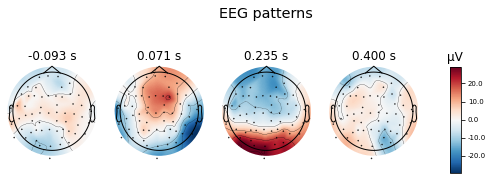

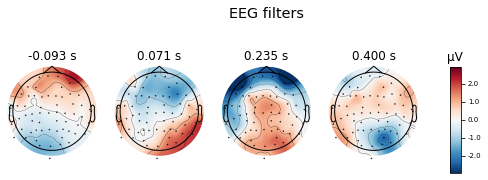

In [10]:
X = epochs.pick_types(meg=False, eeg=True)
y = epochs.events[:, 2]

clf = make_pipeline(
    Vectorizer(),                       
    StandardScaler(),                   
    LinearModel(                        
        LogisticRegression(solver='liblinear')
    )
)
clf.fit(X, y)

for name in ('patterns_', 'filters_'):
 
    coef = get_coef(clf, name, inverse_transform=True)
    evoked = EvokedArray(coef, epochs.info, tmin=epochs.tmin)
    evoked.plot_topomap(title='EEG %s' % name[:-1], time_unit='s')